In [ ]:
%pip install -r requirements.txt

In [ ]:
# %pip install pymongo ollama chromadb pytesseract

In [ ]:
# %source .venv/bin/activate

In [ ]:
!ollama rm openkh
!ollama create openkh -f Makefileqwen

In [2]:
import ollama, chromadb, pytesseract, datetime, re, json
from pymongo import MongoClient

# import pandas_access as mdb
# import pandas as pd

from IPython.display import Image, display
from llama_index.core import SimpleDirectoryReader
from llama_index.core.text_splitter import SentenceSplitter
from llama_index.readers.web import SimpleWebPageReader

from dotenv import dotenv_values

In [3]:
client = chromadb.Client()
collection = client.get_or_create_collection(name="docs")

config = {
    **dotenv_values(".env"),  # load shared development variables
    # **os.environ,  # override loaded values with environment variables
}
embeded_model = config['embeded_model']
chatllm_model = config['chatllm_model']

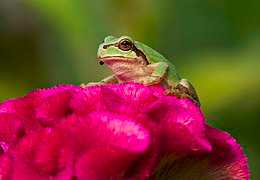

In [4]:
documents = [
    "I am pleased to provide a robust letter of recommendation for RITHYNY LYHAB, endorsing his candidacy for the study exchange program at Institut national des sciences appliquées de Rennes (INSA Rennes). As a Lecturer in the Department of Information and Communication Engineering and Systems Engineering at the Institute of Technology of Cambodia, I have had the privilege of closely observing RITHYNY LYHAB's exceptional academic prowess and personal development.",
    "RITHYNY LYHAB has consistently displayed an unwavering commitment to academic excellence, coupled with an insatiable thirst for knowledge. His diligent work ethic and meticulous attention to detail have consistently yielded remarkable academic achievements. Furthermore, he thrives in collaborative settings, demonstrating strong leadership skills and effective communication abilities while actively contributing to team endeavors.",
    "What truly sets RITHYNY LYHAB apart is his exemplary integrity and dedication to ethical conduct. He serves as a beacon of inspiration, embodying principled actions and a genuine concern for the welfare of others. His ethical foundation, combined with his self-directed learning approach and innovative problem-solving skills, positions him as a valuable asset poised to make significant contributions to his field.",
    "I am confident that RITHYNY LYHAB possesses the intellectual acumen, dedication, and well-rounded attributes necessary to excel in the exchange program at INSA Rennes. His stellar academic performance, exceptional interpersonal skills, and strong ethical compass make him an outstanding candidate who will undoubtedly enhance your academic community.",
    "Should you require further information, please do not hesitate to contact me. I wholeheartedly endorse RITHYNY LYHAB and believe he will be an invaluable addition to your esteemed institution.",
    "Warm regards,",
    "Phearum Nop, Mr",
    'Lecturer',
    """Systems Engineering
    Department of Information and Communication Engineering
    Institute of Technology of Cambodia
    Mobile: +855(0)15949757
    E-mail: nop.phearum@itc.edu.kh; phearum.nop.kh@gmail.com
    """
]
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

pdf = ["./CURRICLUM_VITAE_NOP_PHEARUM.pdf"]

images = ["./image.png"]

# images = []
for i in images:
    display(Image(filename=i,width=200))

In [ ]:
func_calls = [
  {
    "type": "function",
    "function": {
      "name": "add_alarm",
      "description": "Add an alarm to the active timers. Displayed as an alarm for the given time.",
      "parameters": {
        "type": "object",
        "properties": {
          "time": {
            "type": "string",
            "description": "The exact time when the timer should go off, in the format 'YYYY-MM-DD HH:MM:SS'."
          },
          "title": {
            "type": "string",
            "description": "Optional title of the timer."
          }
        },
        "required": ["time"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "add_countdown",
      "description": "Add a countdown timer to the active timers. Displayed as counting down to zero.",
      "parameters": {
        "type": "object",
        "properties": {
          "duration": {
            "type": "string",
            "description": "A duration in ISO 8601 format."
          },
          "title": {
            "type": "string",
            "description": "Optional title of the timer."
          }
        },
        "required": ["duration"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "delete_timer",
      "description": "Cancel one of the active timers",
      "parameters": {
        "type": "object",
        "properties": {
          "id": {
            "type": "string"
          }
        },
        "required": ["id"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "evaluate_expression",
      "description": "Evaluate a mathematical expression in the mathjs syntax",
      "parameters": {
        "type": "object",
        "properties": {
          "expression": {
            "type": "string"
          }
        },
        "required": ["expression"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "get_current_weather",
      "description": "Get the current weather in a given location",
      "parameters": {
        "type": "object",
        "properties": {
          "latitude": {
            "type": "number"
          },
          "longitude": {
            "type": "number"
          }
        },
        "required": ["latitude", "longitude"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "get_weather_forecast",
      "description": "Get the weather forecast for 5 days with data every 3 hours in a given location",
      "parameters": {
        "type": "object",
        "properties": {
          "latitude": {
            "type": "number"
          },
          "longitude": {
            "type": "number"
          }
        },
        "required": ["latitude", "longitude"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "get_places_info",
      "description": "Get information about nearby places using the Google Places API",
      "parameters": {
        "type": "object",
        "properties": {
          "latitude": {
            "type": "number"
          },
          "longitude": {
            "type": "number"
          },
          "radius": {
            "type": "number",
            "description": "The radius in meters around the given location"
          },
          "query": {
            "type": "string",
            "description": "A text query like the name of a nearby place"
          },
          "fields": {
            "type": "array",
            "items": {
              "type": "string"
            },
            "description": "A list of fields to retrieve for each place. Available fields are 'formattedAddress', 'regularOpeningHours', 'currentOpeningHours', 'types', 'rating' and 'websiteUri'"
          },
          "maxResults": {
            "type": "number"
          }
        },
        "required": ["latitude", "longitude", "query", "fields"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "play_on_spotify",
      "description": "Start playing tracks, an album, artist or a playlist on Spotify. Calling this function replaces the current playlist!",
      "parameters": {
        "type": "object",
        "properties": {
          "trackIds": {
            "type": "array",
            "items": {
              "type": "string"
            },
            "description": "Optional. An array of track IDs"
          },
          "contextUri": {
            "type": "string",
            "description": "Optional. The Spotify URI of an album, artist, or playlist."
          }
        },
        "required": []
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "find_artists_and_play_top_songs_on_spotify",
      "description": "Searches for 'queries' on Spotify and plays top songs of the found artist(s). Calling this function replaces the current playlist! Pass multiple artists to one tool invocation to play a mix of top songs from different artists.",
      "parameters": {
        "type": "object",
        "properties": {
          "queries": {
            "type": "array",
            "items": {
              "type": "string"
            },
            "description": "One or more queries to find artists by."
          }
        },
        "required": ["queries"]
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "find_on_spotify",
      "description": "Find tracks, artists, albums or playlists on Spotify",
      "parameters": {
        "type": "object",
        "properties": {
          "query": {
            "type": "string"
          },
          "types": {
            "type": "array",
            "items": {
              "type": "string"
            },
            "description": "Types to search across. Valid types are: 'track', 'artist', 'album', 'playlist', 'show', and 'episode'."
          },
          "limit": {
            "type": "integer",
            "description": "The maximum number of items to return"
          }
        },
        "required": ["query", "types"]
      }
    }
  }
]

In [ ]:
images = []
for i in range(3,6):
    image = f"./slide-ai/ai-chatbot-{i}.jpg"
    images.append(image)
    display(Image(filename=image,width=200))

In [ ]:
# images = ["./image.png","./image2.png"]
textImages = []
for img in images:
    text = pytesseract.image_to_string(img)
    textImages.append(text.replace("\n\n°","\n"))
    
textImages

In [ ]:
dbclient = MongoClient("localhost", 27017)

class DBchat:
    def __init__(self) -> None:
        self.db = dbclient['chatllama']

    def list_docs(self):
        return self.db.list_collection_names()
        
    def documents(self, user_id, chat_id):
        return self.db.document.find_one({'_id': chat_id, 'user_id': user_id})
    
    def insert_one(self, group_id: str, docs={}):
        docs['group_id'] = group_id
        docs['datetime'] = datetime.datetime.now()
        return self.db.chats.insert_one(docs)
    
    def insert_many(self, group_id: str, docs=[]):
        for i in docs:
            docs[i]['group_id'] = group_id
            docs[i]['datetime'] = datetime.datetime.now()
        return self.db.chats.insert_many(docs)
    
    def insert_into_group(self, user_id: str, group_id: str):
        return self.db.groupchats.insert_one({
            'user_id': user_id,
            'group_id': group_id,
            'datetime': datetime.datetime.now()
        })

In [5]:
chatpromt = """Using this
datetime:
{datetime}
document:
{document}
history:
{history}
If document/history is empty, please just reponse to the question and reject all following prompt.
Apply all data which relate, base answer, only data with prompt question as short as you can.
Respond to this prompt:
{prompt}"""

class AIChat:
    def __init__(self):
        self.ai = ollama
        self.name_docs = "docs"
        # self.vx = VectorStoreIndex()
        self.collection = client.get_or_create_collection(name=self.name_docs)
        self.text_splitter = SentenceSplitter(chunk_size=90240, chunk_overlap=100)

    def docs(self, name="docs"):
        self.collection = client.get_or_create_collection(name=name)

    def load_url(self, urls=[]):
        docs = SimpleWebPageReader(html_to_text=True).load_data(urls)
        doc_splits = self.text_splitter.get_nodes_from_documents(docs)
        chunks = [node.get_content() for node in doc_splits]
        self.embedded(doc_splits=chunks)

    def load_docs(self, docs=[]):
        self.embedded(doc_splits=docs)

    def load_function(self, funcs=[]):
        text_representation = []
        for data in funcs:
            text_representation.append(json.dumps(data))
        print(text_representation)
        self.embedded(doc_splits=text_representation)

    def load_pdf(self, pdf_file_path=[]):
        docs = SimpleDirectoryReader(input_files=pdf_file_path).load_data()
        chunks = self.text_splitter.get_nodes_from_documents(docs)
        chunks = [node.get_content() for node in chunks]
        self.embedded(doc_splits=chunks)

    def get_meta(file_path, text):
        return {
            "text": text,
            "file_path": file_path
        }

    def load_dir(self, path_dir: str):
        reader = SimpleDirectoryReader(input_dir=path_dir, required_exts=[".csv", ".pdf", ".docx", ".txt", ".md", ".ppt", ".pptm," ".pptx"], recursive=True)
        all_docs = []
        for docs in reader.iter_data():
            chunks = self.text_splitter.get_nodes_from_documents(docs)
            chunks = [node.get_content() for node in chunks]
            all_docs.extend(chunks)
        self.embedded(doc_splits=all_docs)

    def load_img(self, images_path=[]):
        texts = []
        docs = self.load_textimg(image_dir=images_path)
        new_path = []
        for text in docs:
            if text[1] != '':
                texts.append(text)
            else:
                new_path.append(text[0]['file_path'])

        res = self.ai.generate(
            model='llava:7b',
            prompt=f"Short, Meaning, Using data:\n{texts}\n Please discript what is in this image:",
            images=new_path,
            stream=True
        )
        for text in res:
            if text['done'] is True:
                break
            print(text['response'], end="", flush=True)
            texts.append(text['response'])
        join_str = ""
        if len(texts) > 1:
            join_str = "\n"

        texts = join_str.join(texts)
        self.embedded(doc_splits=[texts])

    def load_textimg(self, images_path=[], image_dir=""):
        if image_dir == "" and len(images_path)>0:
            docs = SimpleDirectoryReader(input_files=images_path).load_data()
        elif len(images_path)==0 and image_dir != "":
            docs = SimpleDirectoryReader(input_dir=image_dir).load_data()

        chunks = self.text_splitter.get_nodes_from_documents(docs)
        return [
            [{k[0]:k[1] for k in [i.split(": ") for i in node.get_metadata_str().split("\n")]},node.get_content()] 
            for node in chunks
        ]

    # store each document in a vector embedding database
    def embedded(self, doc_splits=[]):
        for i, d in enumerate(doc_splits):
            if type(d) is not str:
                d = d.page_content

            response = self.ai.embeddings(model=embeded_model, prompt=d)
            embedding = response["embedding"]
            self.collection.add(
                ids=[str(i)],
                embeddings=[embedding],
                documents=[d]
            )

    def lists(self):
        return self.ai.list()

    def chat(self, prompt=None, messages=[], history=[], chatllm_model=chatllm_model, embeded_model=embeded_model, stream=True):
        if len(messages) > 0:
            prompt = messages[len(messages)-1]["content"]

        response = self.ai.embeddings(model=embeded_model, prompt=prompt)
        results = self.collection.query(
            query_embeddings=[response["embedding"]], n_results=2)
        # print(results)
        if results['documents']:
            docs = '\n\n'.join(results['documents'][0])
        else:
            docs = ""

        prompt = chatpromt.format(document=docs, history=history, prompt=prompt, datetime=datetime.date.today())
        if len(messages) > 0:
            return self.ai.chat(model=chatllm_model, messages=messages, stream=stream)

        res = self.ai.generate(chatllm_model, prompt=prompt.replace("\n\n\n", "\n"), stream=stream)
        for content in res:
            print(content['response'], end="", flush=True)

    def extract_urls(self, text):
        # Regular expression pattern to match URLs
        url_pattern = r'https?://\S+'
        # Find all URLs in the text
        urls = re.findall(url_pattern, text)
        return urls

# ai = AIChat()
# ai.docs(name="image")
# docs = ai.load_textimg(images_path=images)
# docs

In [ ]:
ai = AIChat()
ai.docs(name="docs")

In [ ]:
ai.load_img(images_path="./docs")

In [ ]:
ai = AIChat()
ai.docs(name="funcalls")

In [ ]:
ai.load_function(funcs=func_calls)

In [21]:
text = "Give me information about nearby Phnom Penh location"
ai.chat(text)

📍 **Phnom Penh Attractions and Locations**  

Here's a list of notable locations near Phnom Penh to explore:

- **Royal Palace (ប្រាសាធនរត់)**  
  A stunning example of French colonial architecture, the Royal Palace houses the Silver Pagoda and the National Museum.

- **National Museum of Cambodia (រាជណត្បលេសាទ)**  
  Showcasing over 10,000 artifacts spanning from prehistoric to modern times, the museum provides insights into the country's rich history.

- **Wat Phnom (ភ្នំវត្ផ)**  
  The sacred hill where Wat Phnom stands has deep cultural and historical significance for Cambodians. It is also a popular spot with an enchanting atmosphere.

- **Tuol Sleng Genocide Museum (សាស្រ្�os្រៀនទឹកនំបញ្ចុកដែនតួរ)**  
  Once a high school, the site now serves as a sobering reminder of Cambodia's tragic past under Pol Pot' Authorities. It offers valuable insights into genocide and human rights issues.

- **Mekong River (មក្ស៊ុង)**  
  A key geographical feature, the Mekong is one of Asia's longest

In [ ]:
ai = AIChat()
ai.docs(name="pdf")
ai.load_pdf(pdf_file_path=pdf)

In [ ]:
ai = AIChat()
ai.docs(name="image")
ai.load_img(images_path=images)

In [ ]:
ai = AIChat()
ai.docs(name="path")
docs = ai.load_dir(path_dir="../")
docs

In [ ]:
ai = AIChat()
ai.docs(name="pdf")
ai.load_pdf(pdf_file_path=pdf)

In [7]:
ai = AIChat()

In [10]:
ai.chat("Hello, Do you know Mr.Phearum?")

👋 Hello! Yes, I'm aware of Mr. Phearum. He is an alumnus of the Systems Engineering Department at the Institute of Technology of Cambodia (ITC). You can reach him through his mobile number +855(0)15949757 or via email: nop.phearum@itc.edu.kh; phearum.nop.kh@gmail.com.

📅 **Date**: 2024-07-12  
🏛️ **Institution**: Institute of Technology of Cambodia (ITC)  
🎓 **Department**: Systems Engineering  
📞 **Contact Number**: +855(0)15949757  
💌 **Email Addresses**: nop.phearum@itc.edu.kh; phearum.nop.kh@gmail.com

*Note that the history section is empty, so no additional personal data beyond what's relevant to this interaction was provided.*

In [9]:
ai.docs(name='docs')
ai.load_docs(docs=documents)

In [ ]:
ai = AIChat()

In [ ]:
ai.chat("Helo! Who are you?")